In [8]:
import numpy as np
import pandas as pd
import os

In [9]:
from sklearn.model_selection import train_test_split,RepeatedKFold, cross_val_score,KFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import model_selection

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
from eli5 import explain_weights,show_weights
from yellowbrick import ROCAUC
from yellowbrick.classifier import ClassificationReport

In [17]:
print("Imported all libraries successfully")
print(os.listdir())

Imported all libraries successfully
['.config', 'VLagun_Phys_Years3.csv', 'Tourists_lakes_Nature.csv', 'sample_data']


In [18]:
CV_N_REPEATS=5
BINS=10

In [20]:
df = pd.read_csv("/content/VLagun_Phys_Years3.csv")
df.head()

,PSU,O2,temp.,SS,DOC,TPOC,Windspeedinsitu,Depth,Years
0,3.757624,9.46,18.3,52.0,7.500,8.5650,3.5,3.3,0
1,3.504707,9.89,19.1,50.0,7.860,8.5200,0.0,3.6,0
2,3.757624,9.66,18.1,59.0,8.172,8.4915,1.0,3.4,0
3,3.107266,10.36,19.5,46.0,7.848,8.8320,0.0,2.9,0
4,2.619498,11.56,19.0,42.0,7.536,9.2400,0.0,3.0,0


In [21]:
print('Shape of the dataset', df.shape)

Shape of the dataset (120, 9)


Text(0, 0.5, 'Years')

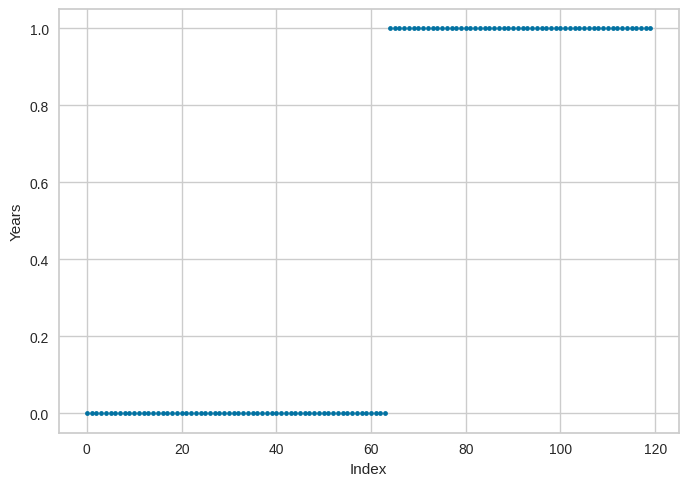

In [22]:
plt.figure()
plt.plot(df.Years,'.')
plt.xlabel('Index')
plt.ylabel('Years')

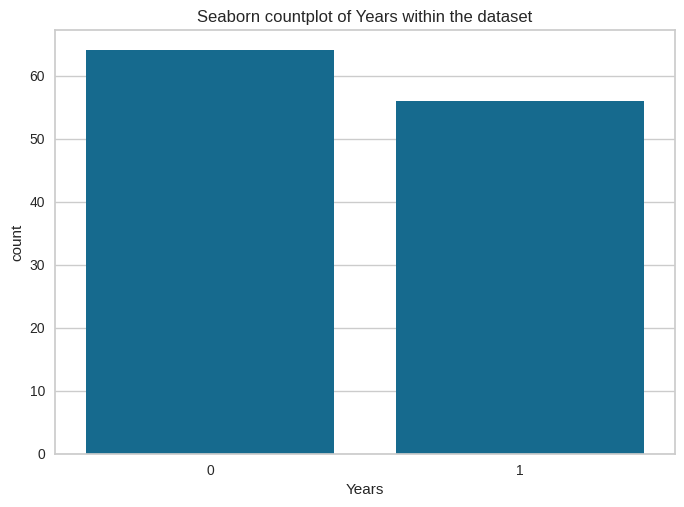

In [23]:
plt.figure()
ax = sns.countplot(data=df, x='Years');
ax.set_title("Seaborn countplot of Years within the dataset");


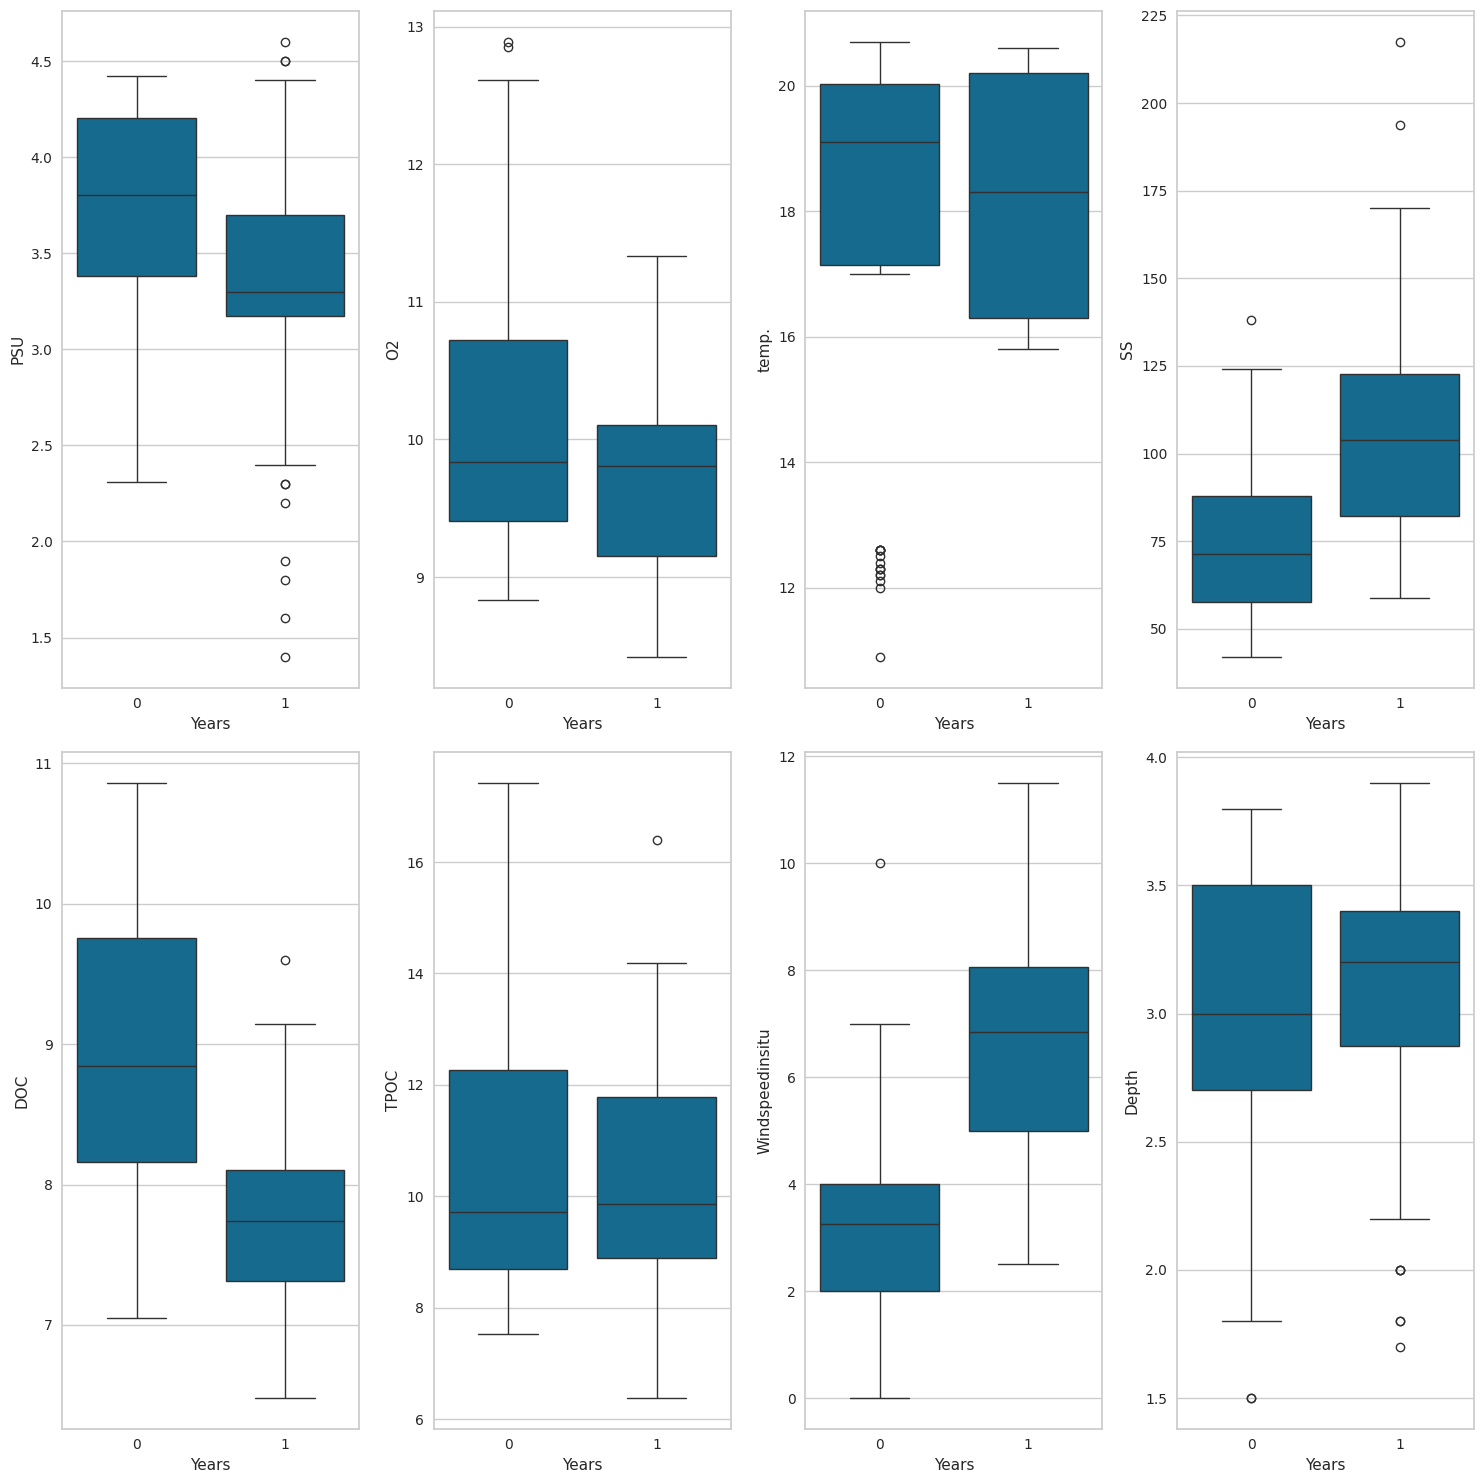

In [24]:
f, axes = plt.subplots(2, 4,figsize=(15,15))
sns.set(style="white", palette="Set3", color_codes=True)
sns.boxplot( y="PSU", x= "Years", data=df, orient='v', ax=axes[0,0])
sns.boxplot( y="O2", x= "Years", data=df, orient='v' , ax=axes[0,1])
sns.boxplot( y="temp.", x= "Years", data=df, orient='v' ,ax=axes[0,2])
sns.boxplot( y="SS", x= "Years", data=df, orient='v' , ax=axes[0,3])
sns.boxplot( y="DOC", x= "Years", data=df, orient='v' , ax=axes[1,0])
sns.boxplot( y="TPOC", x= "Years", data=df, orient='v' , ax=axes[1,1])
sns.boxplot( y="Windspeedinsitu", x= "Years", data=df, orient='v' , ax=axes[1,2])
sns.boxplot( y="Depth", x= "Years", data=df, orient='v' , ax=axes[1,3])

f.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
               hspace=0.4, wspace=0.3)
plt.tight_layout()

In [25]:
df_copy = df.copy(deep = True)
df_copy[['PSU','O2','temp.','SS','DOC','TPOC','Windspeedinsitu','Depth']] = df_copy[['PSU','O2','temp.','SS','DOC','TPOC','Windspeedinsitu','Depth']]
print('Number of zero entries in each attribute:\n')
print(df_copy.isnull().sum())

Number of zero entries in each attribute:

PSU                0
O2                 0
temp.              0
SS                 0
DOC                0
TPOC               0
Windspeedinsitu    0
Depth              0
Years              0
dtype: int64


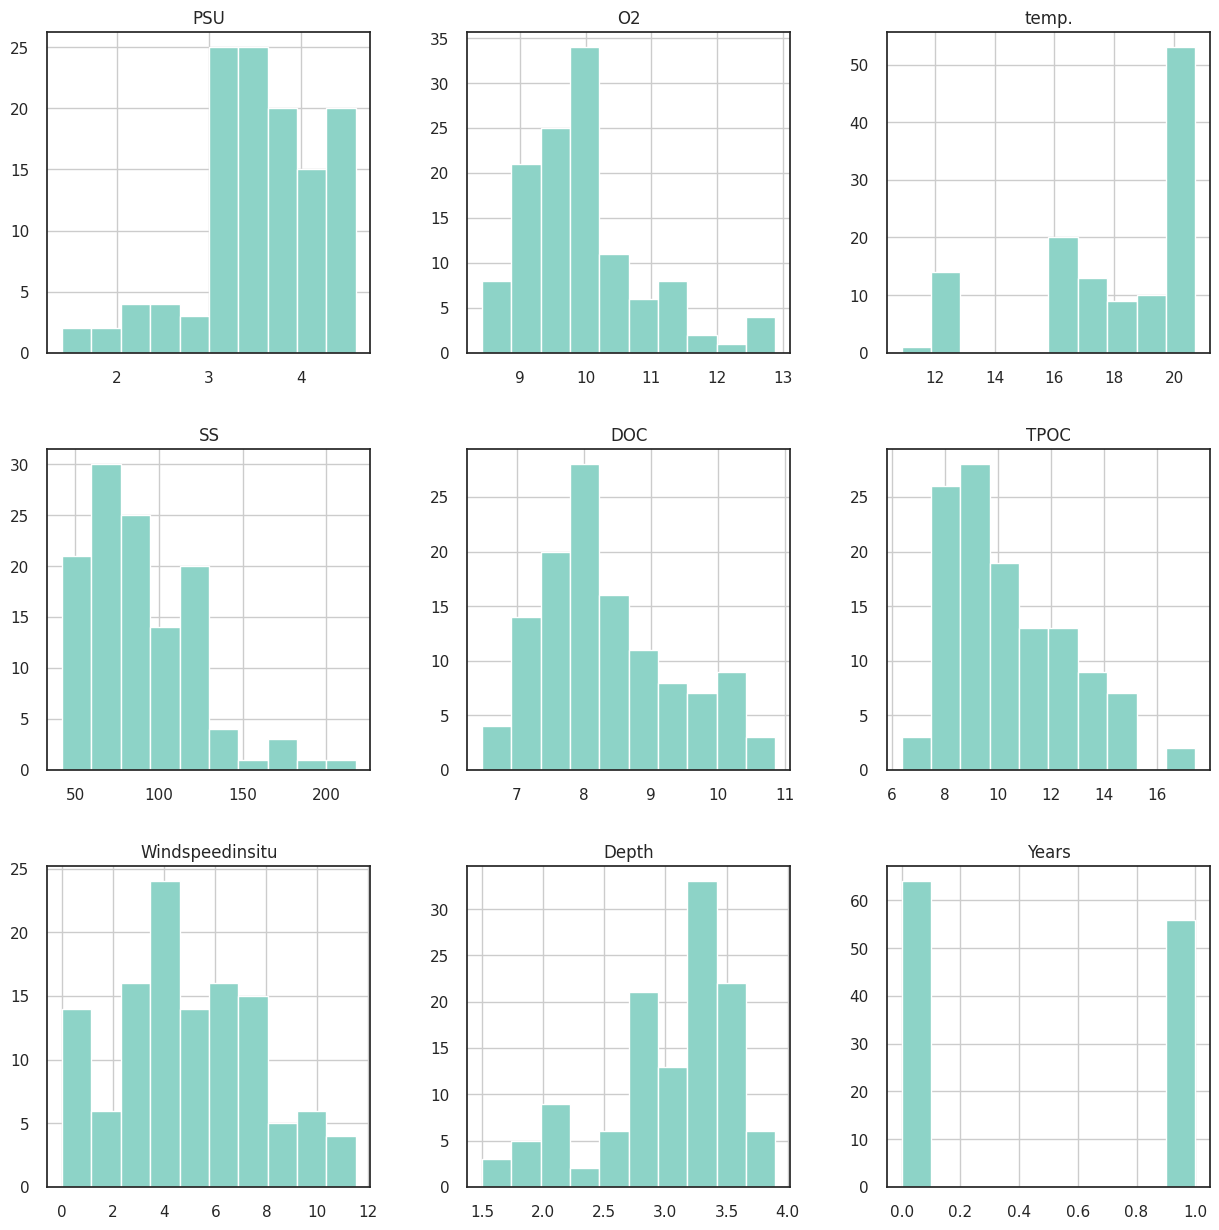

In [26]:
p = df.hist(figsize=(15,15))

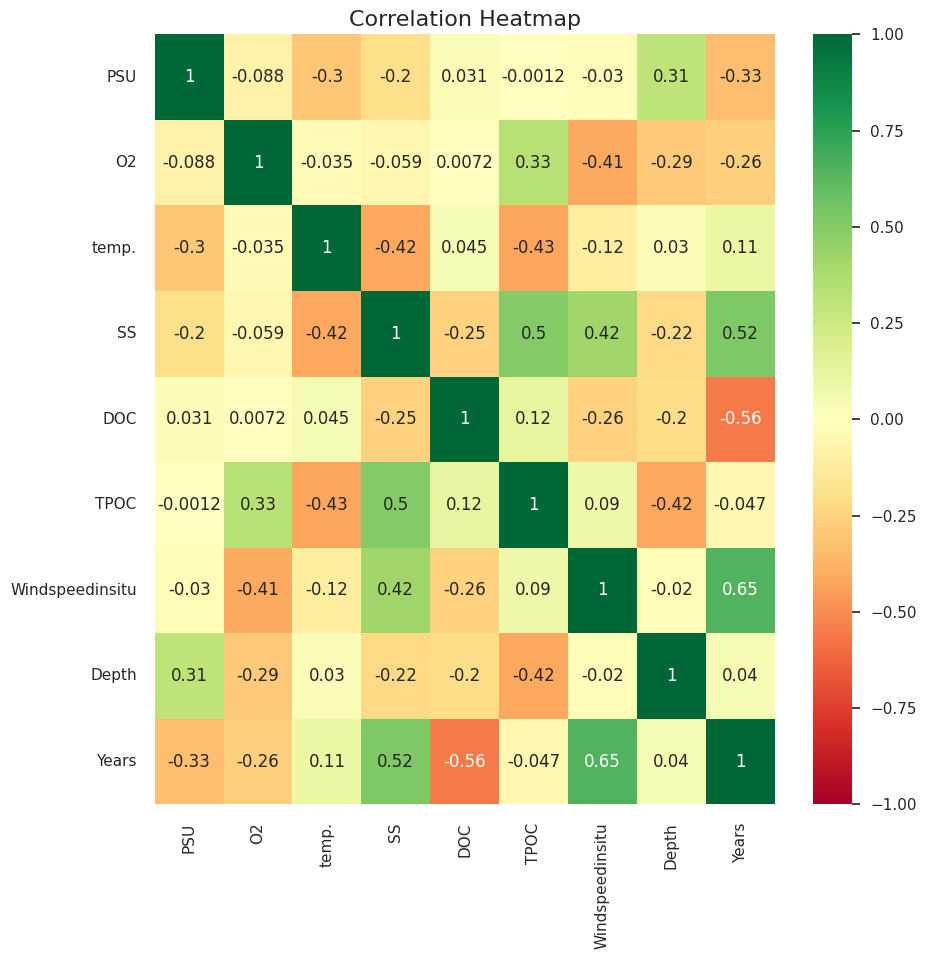

In [27]:
plt.figure(figsize=(10,10))
corr = df_copy.corr()
corr.index = df_copy.columns
sns.heatmap(corr, annot = True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

<Figure size 800x550 with 0 Axes>

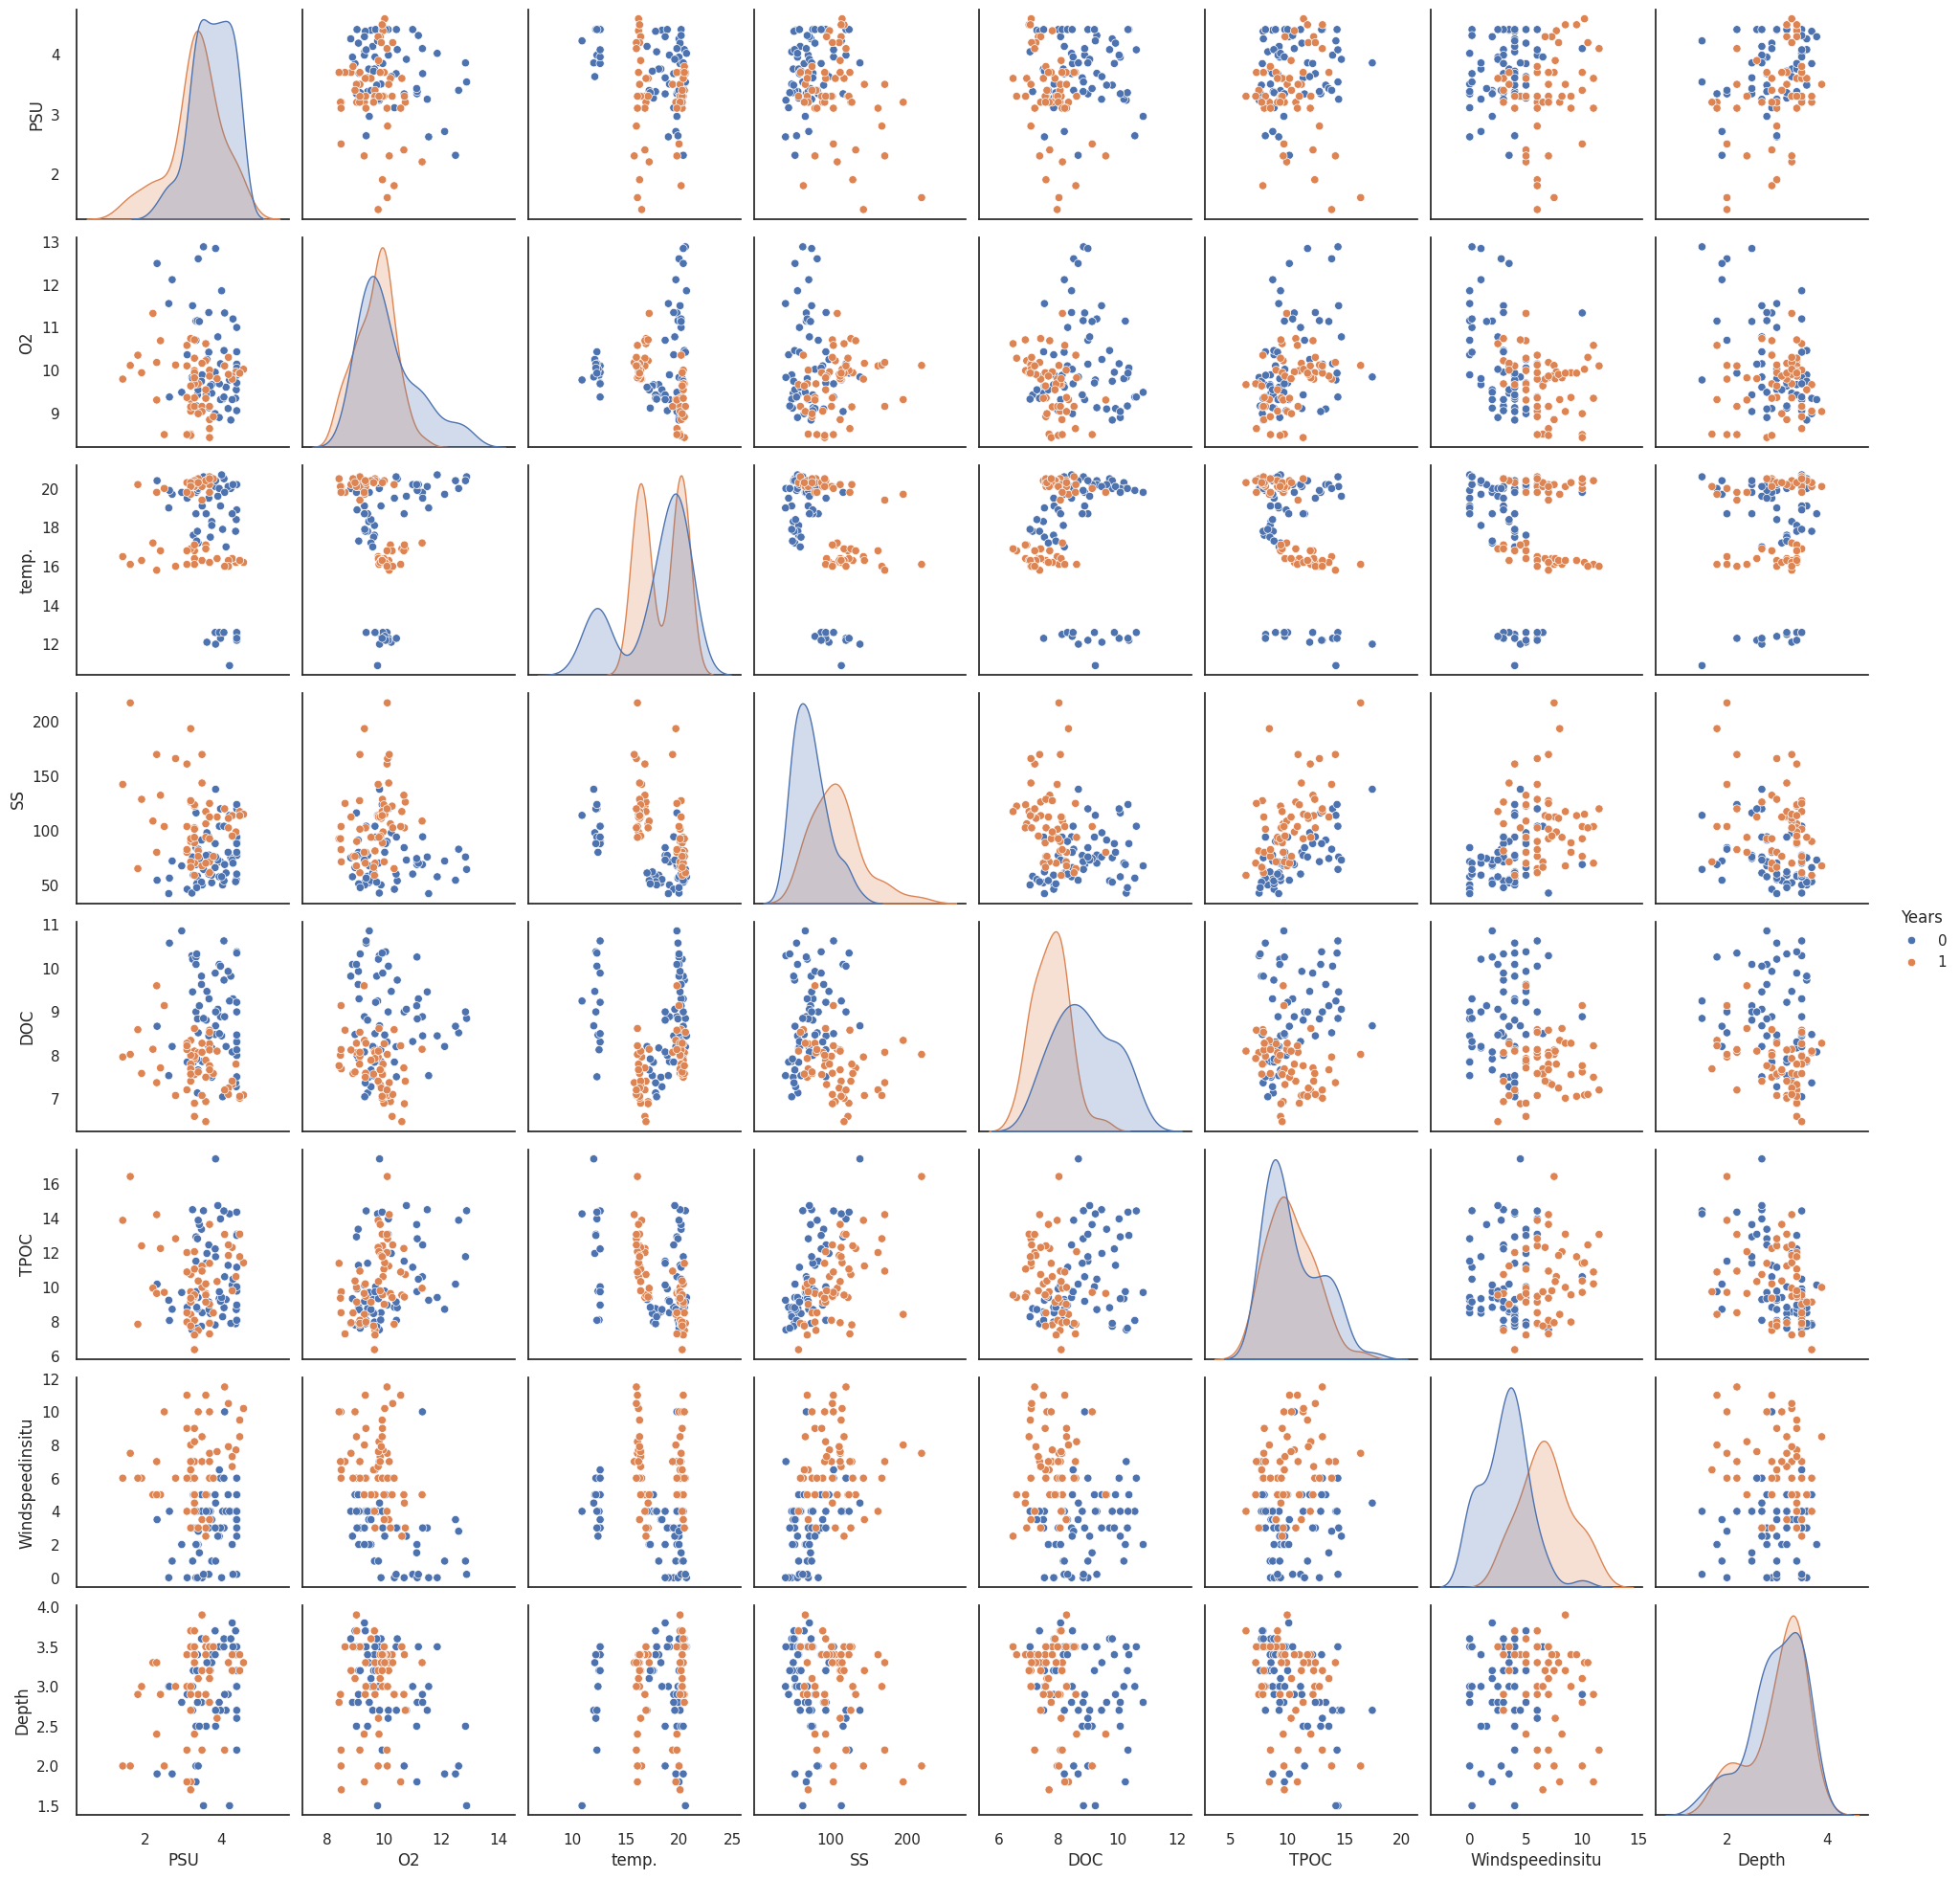

In [28]:
plt.figure()
sns.pairplot(data=df_copy,hue='Years',diag_kind='kde', palette='deep');

In [30]:
X = df_copy.iloc[:, :-1]
Y = df_copy.iloc[:, -1]
seed = 7
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (84, 8)
Shape of X_test: (36, 8)


In [31]:
dum=DummyClassifier(strategy='most_frequent')
dum=dum.fit(X_train,y_train)

score=dum.score(X_test, y_test)
print("Dummy Classifier Accuracy: %.2f%%" % (score * 100.0))

Dummy Classifier Accuracy: 47.22%


<Figure size 700x700 with 0 Axes>

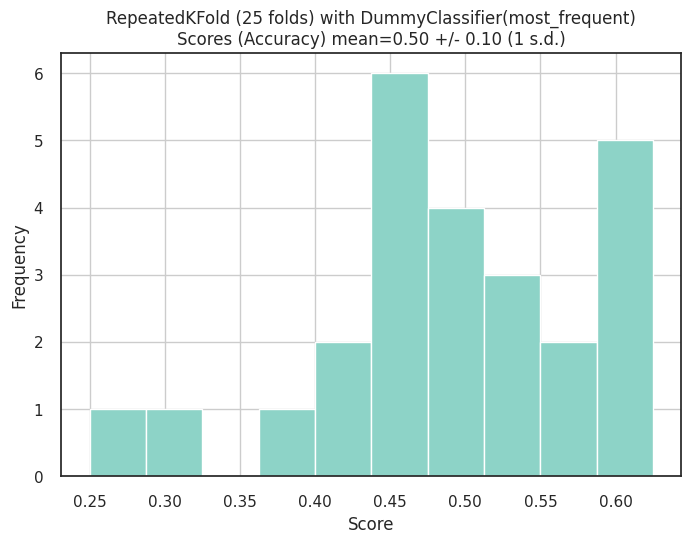

In [32]:
strategy = "most_frequent"

scores = cross_val_score(dum,X, Y,
                       cv=RepeatedKFold(n_repeats=CV_N_REPEATS),
                       scoring=None)

scores_dummy = scores.copy()

score_line = "Scores (Accuracy) mean={0:.2f} +/- {1:.2f} (1 s.d.)".format(scores.mean(),scores.std())
plt.figure(figsize=(7,7))
fig, ax = plt.subplots()
pd.Series(scores).hist(ax=ax, bins=BINS)
ax.set_title(f"RepeatedKFold ({len(scores)} folds) with DummyClassifier({strategy})\n" + score_line);
ax.set_xlabel("Score")
ax.set_ylabel("Frequency");

In [33]:
def plot_tree_graph(model,columns,class_names):
   dot_data = export_graphviz(model,feature_names=columns,class_names=class_names)
   graph = graphviz.Source(dot_data)
   return graph

def confusion_mat(y_pred,y_test):
   plt.figure()
   sns.set(font_scale=1.5)
   cm = confusion_matrix(y_pred, y_test)
   sns.heatmap(cm, annot=True, fmt='g')
   plt.title('Confusion matrix', y=1.1)
   plt.ylabel('Actual label')
   plt.xlabel('Predicted label')
   plt.show()

In [34]:
dt=DecisionTreeClassifier(random_state=1, max_depth=3)
dt=dt.fit(X_train,y_train)
dt_scores = cross_val_score(dt, X, Y, cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))
print(f"Accuracy mean={dt_scores.mean():.2f} +/- {dt_scores.std():.2f} (1 s.d.)")

Accuracy mean=0.86 +/- 0.06 (1 s.d.)


In [35]:
bag=BaggingClassifier(n_estimators=100,oob_score=True)
bag=bag.fit(X_train,y_train)

bag_scores = cross_val_score(bag, X, Y, cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))
print("Accuracy mean={0:0.2f} +/- {1:0.2f} (1 s.d.)".format(bag_scores.mean(),bag_scores.std()))
print("Out of bag score: {0:0.2f}".format(bag.oob_score_*100) );

Accuracy mean=0.90 +/- 0.08 (1 s.d.)
Out of bag score: 94.05


Accuracy of Random Forest Classifier: 88.89


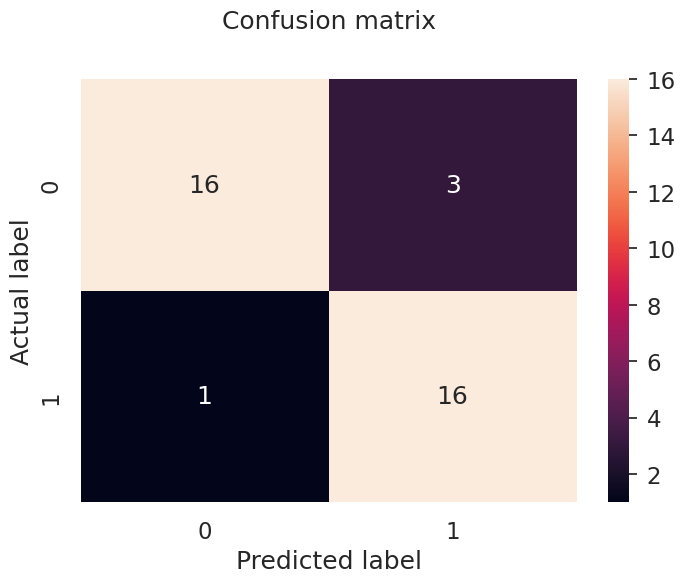

In [36]:
num_estimators=100
rf = RandomForestClassifier(n_estimators=num_estimators)
rf.fit(X_train, y_train)

rf_score=rf.score(X_test, y_test)
print("Accuracy of Random Forest Classifier: {0:0.2f}".format(rf_score * 100.0));

y_pred = rf.predict(X_test)
confusion_mat(y_pred, y_test)

In [37]:
feature_names=X_train.columns.values
show_weights(rf,feature_names=feature_names)

Weight,Feature
0.2862 ± 0.4621,Windspeedinsitu
0.2210 ± 0.3506,DOC
0.1490 ± 0.2909,SS
0.1126 ± 0.2243,temp.
0.0956 ± 0.2087,PSU
0.0524 ± 0.1348,O2
0.0523 ± 0.1244,TPOC
0.0310 ± 0.1010,Depth


Scores mean=0.94 +/- 0.05 (1 s.d.)


<Figure size 800x550 with 0 Axes>

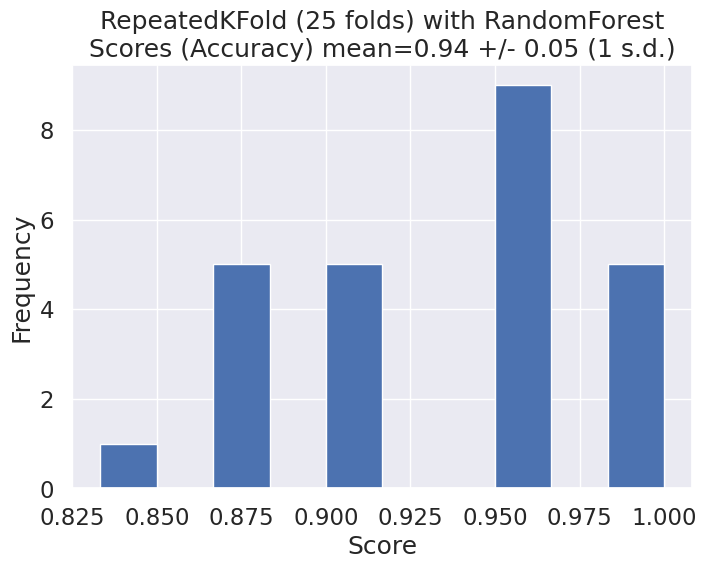

In [38]:
scores = cross_val_score(rf, X, Y, cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))
scores_est = scores.copy()
print(f"Scores mean={scores.mean():0.2f} +/- {scores.std():0.2f} (1 s.d.)")

score_line = f"Scores (Accuracy) mean={scores.mean():0.2f} +/- {scores.std():0.2f} (1 s.d.)"
plt.figure()
fig, ax = plt.subplots()
pd.Series(scores).hist(ax=ax, bins=BINS)
ax.set_title(f"RepeatedKFold ({len(scores)} folds) with RandomForest\n" + score_line);
ax.set_xlabel("Score")
ax.set_ylabel("Frequency");

In [44]:
from sklearn.metrics import log_loss, mean_squared_error
params={'n_estimators': 500,'learning_rate': 0.01,'max_depth': 5, 'loss':'log_loss'}
gbm=GradientBoostingClassifier(**params)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, n_estimators=500)

Text(0, 0.5, 'Deviance')

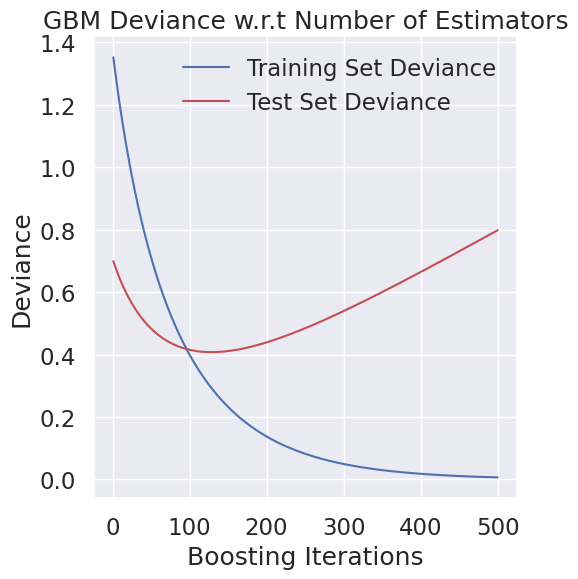

In [45]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred_proba in enumerate(gbm.staged_predict_proba(X_test)):
    test_score[i] = log_loss(y_test, y_pred_proba)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('GBM Deviance w.r.t Number of Estimators')
plt.plot(np.arange(params['n_estimators']) + 1, gbm.train_score_, 'b-',label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='best')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

Accuracy of GBM Classifier: 86.11


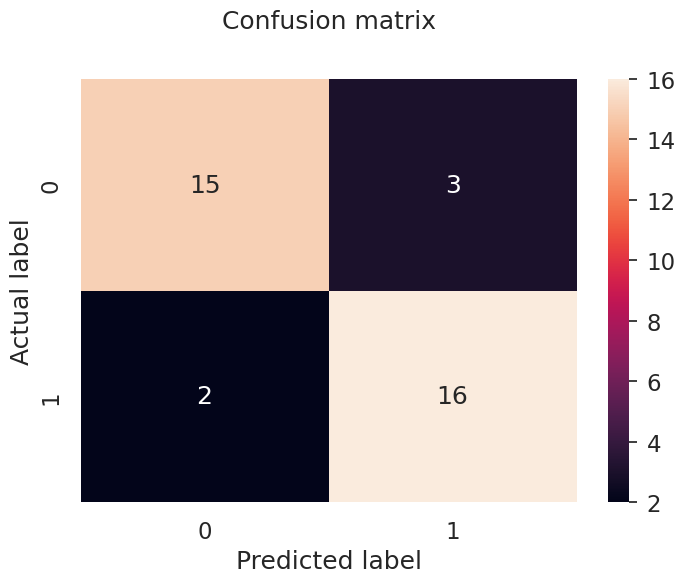

In [46]:
params={'n_estimators': 100,'learning_rate': 0.01,'max_depth': 4, 'loss':'log_loss'}
gbm=GradientBoostingClassifier(**params)
gbm.fit(X_train, y_train)

y_pred = gbm.predict(X_test)

gbm_score = accuracy_score(y_test, y_pred)
print("Accuracy of GBM Classifier: {0:0.2f}".format(gbm_score * 100.0));

confusion_mat(y_pred, y_test)

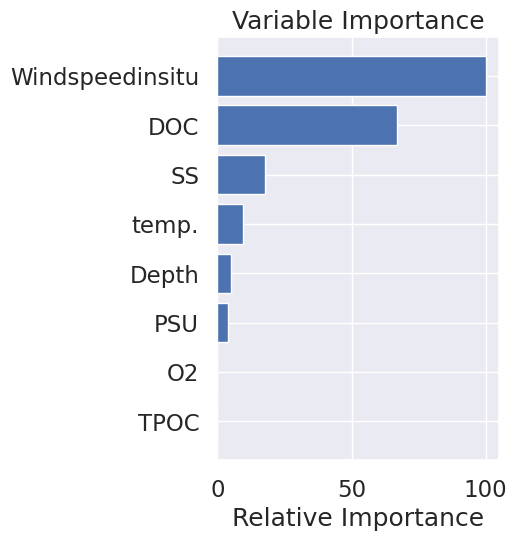

In [47]:
feature_importance = gbm.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [49]:
from xgboost import XGBClassifier, plot_importance,to_graphviz

param = {'max_depth': 10, 'eta': 0.8, 'subsample':1, 'objective': 'binary:logistic', 'n_estimators': 1000, 'learning_rate': 0.001}
xgb = XGBClassifier(**param)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.8, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

Accuracy of GBM Classifier: 86.11


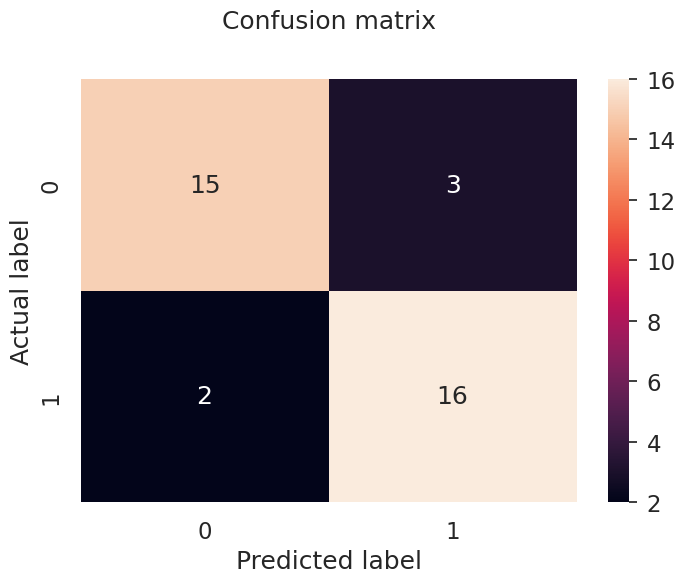

In [50]:
params={'n_estimators': 100,'learning_rate': 0.01,'max_depth': 4, 'loss':'log_loss'}
gbm=GradientBoostingClassifier(**params)
gbm.fit(X_train, y_train)

y_pred = gbm.predict(X_test)

gbm_score = accuracy_score(y_test, y_pred)
print("Accuracy of GBM Classifier: {0:0.2f}".format(gbm_score * 100.0));

confusion_mat(y_pred, y_test)

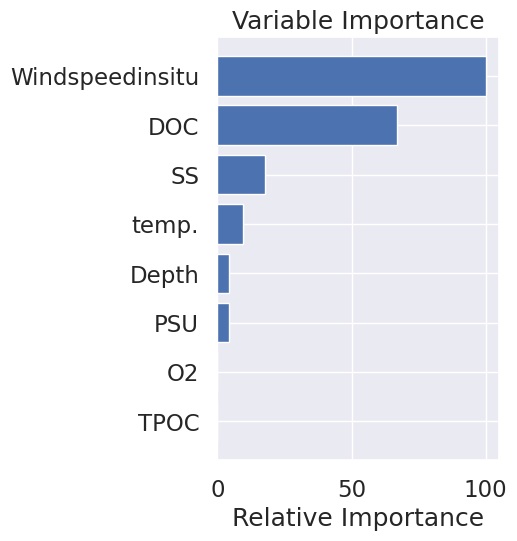

In [51]:
feature_importance = gbm.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [52]:
from xgboost import XGBClassifier, plot_importance,to_graphviz

param = {'max_depth': 10, 'eta': 0.8, 'subsample':1, 'objective': 'binary:logistic', 'n_estimators': 1000, 'learning_rate': 0.001}
xgb = XGBClassifier(**param)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.8, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

Accuracy of XGB Classifier: 77.78


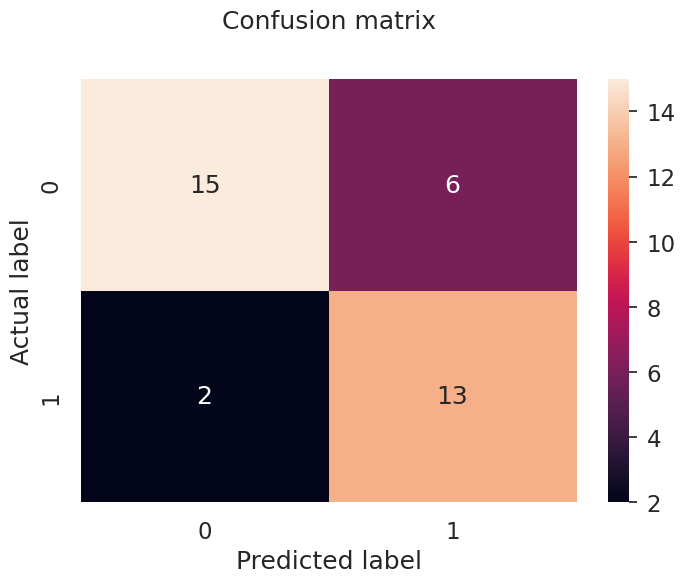

In [53]:
y_pred = xgb.predict(X_test)

xgb_score = accuracy_score(y_test, y_pred)
print("Accuracy of XGB Classifier: {0:0.2f}".format(xgb_score * 100.0));

confusion_mat(y_pred, y_test)


<Figure size 800x550 with 0 Axes>

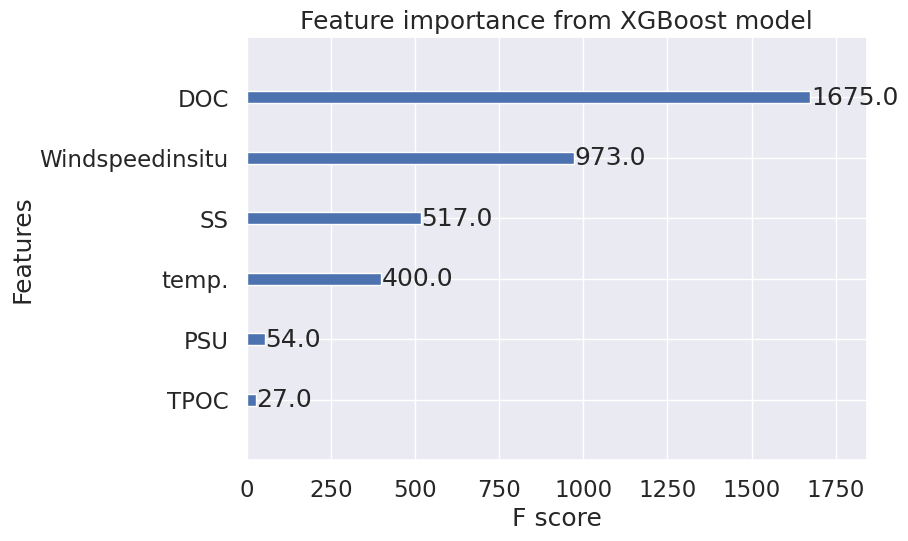

In [54]:
plt.figure()
plot_importance(xgb,title="Feature importance from XGBoost model")
plt.show()

In [55]:
import shap
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import tree

In [57]:
data = pd.read_csv("/content/VLagun_Phys_Years3.csv")

data.dropna(inplace=True)
X = pd.get_dummies(data)
X.drop(['Years'], inplace=True, axis=1)
y = data['Years']

data.head()

,PSU,O2,temp.,SS,DOC,TPOC,Windspeedinsitu,Depth,Years
0,3.757624,9.46,18.3,52.0,7.500,8.5650,3.5,3.3,0
1,3.504707,9.89,19.1,50.0,7.860,8.5200,0.0,3.6,0
2,3.757624,9.66,18.1,59.0,8.172,8.4915,1.0,3.4,0
3,3.107266,10.36,19.5,46.0,7.848,8.8320,0.0,2.9,0
4,2.619498,11.56,19.0,42.0,7.536,9.2400,0.0,3.0,0


In [58]:
X = X.iloc[:,0:8]
y = y.iloc[:]
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (84, 8)
Shape of X_test: (36, 8)


In [59]:
model = XGBClassifier(n_estimators=1000, max_depth=10, learning_rate=0.001)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [60]:
y_pred = model.predict(X_test)

model_score = accuracy_score(y_test, y_pred)
print("Accuracy of XGB Classifier: {0:0.2f}".format(model_score * 100.0));

confusion_matrix(y_pred, y_test)

Accuracy of XGB Classifier: 88.89


array([[15,  1],
       [ 3, 17]])

In [61]:
shap.initjs()

In [64]:
from google.colab import output
output.enable_custom_widget_manager()

# Then run initjs again
shap.initjs()


In [65]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

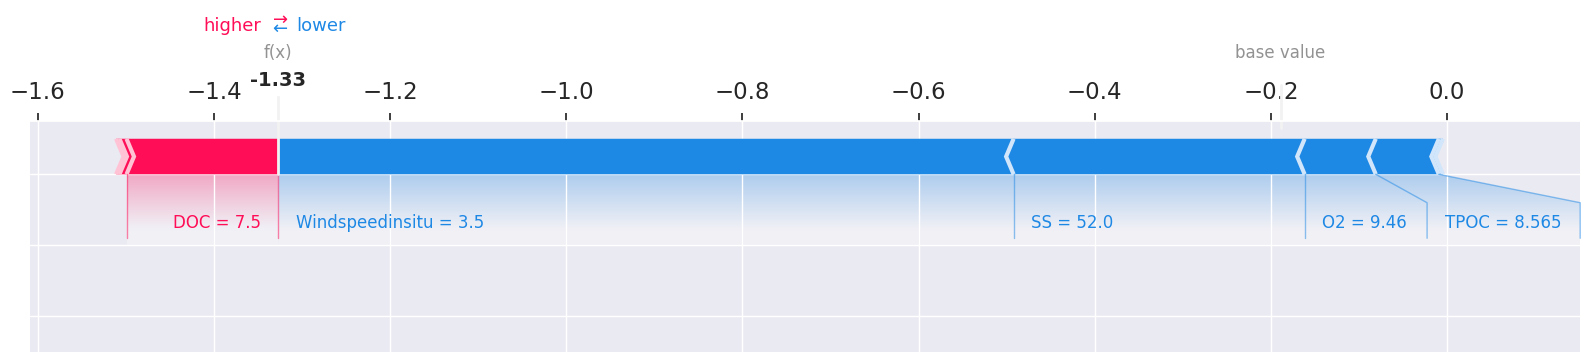

In [67]:
i = 0
shap.force_plot(explainer.expected_value, shap_values[0], features=X.iloc[0], feature_names=X.columns, matplotlib=True)


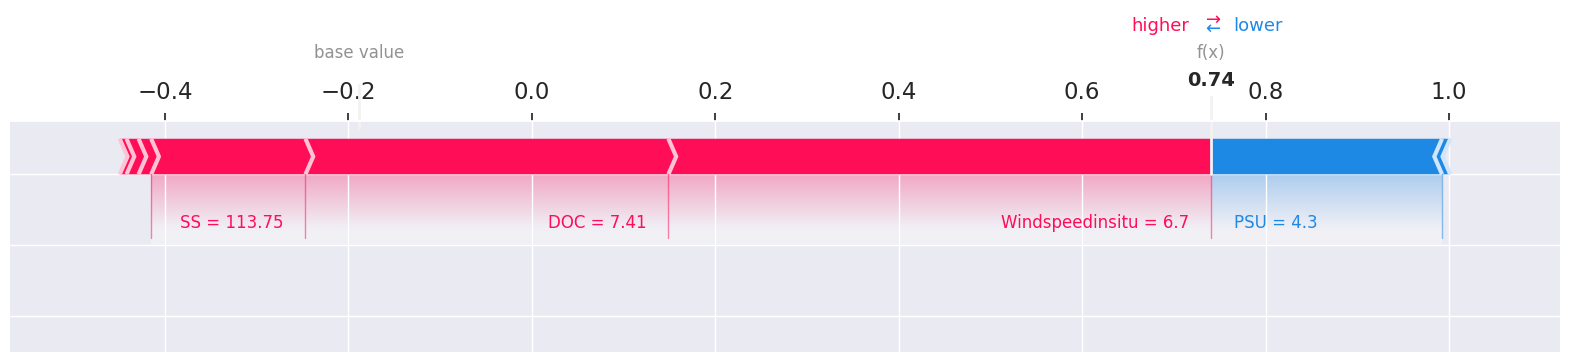

In [69]:
i = 109
shap.force_plot(explainer.expected_value, shap_values[i], features=X.iloc[i], feature_names=X.columns, matplotlib=True)



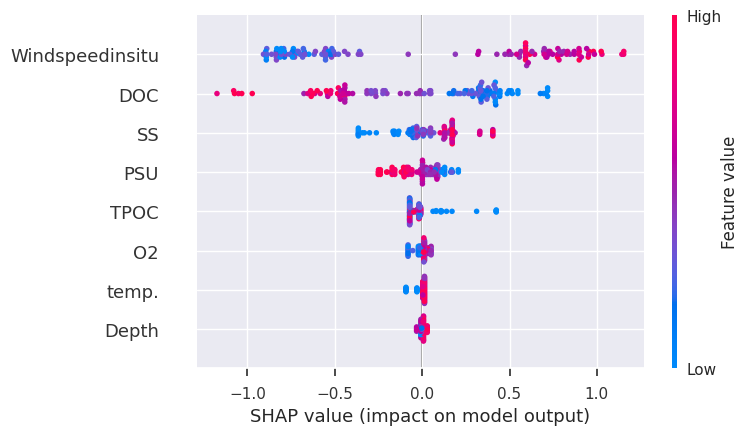

In [70]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns, show=False)
plt.savefig('plot.png', dpi=300, bbox_inches='tight')

plt.show()

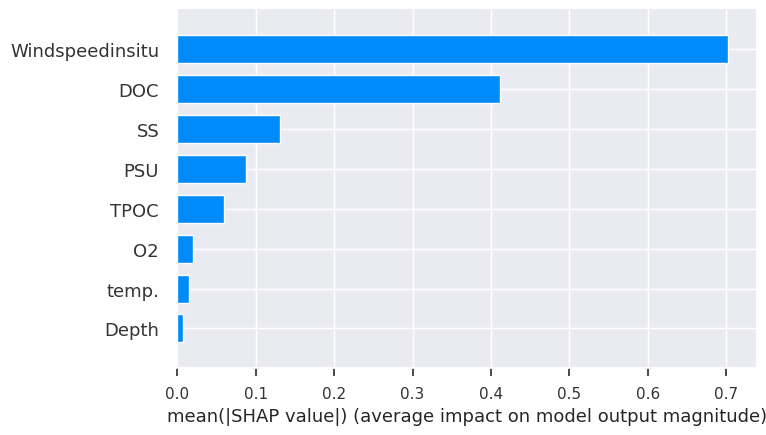

In [71]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns, show=False, plot_type='bar')
plt.savefig('plot.png', dpi=300, bbox_inches='tight')

plt.show()

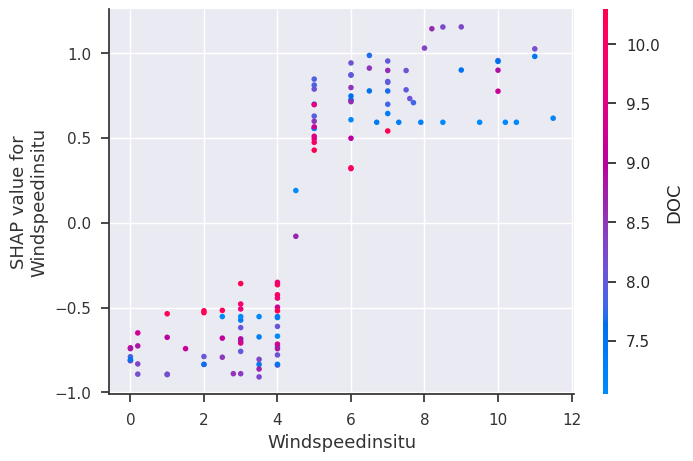

In [72]:
shap.dependence_plot("Windspeedinsitu", shap_values, features=X, interaction_index="DOC")


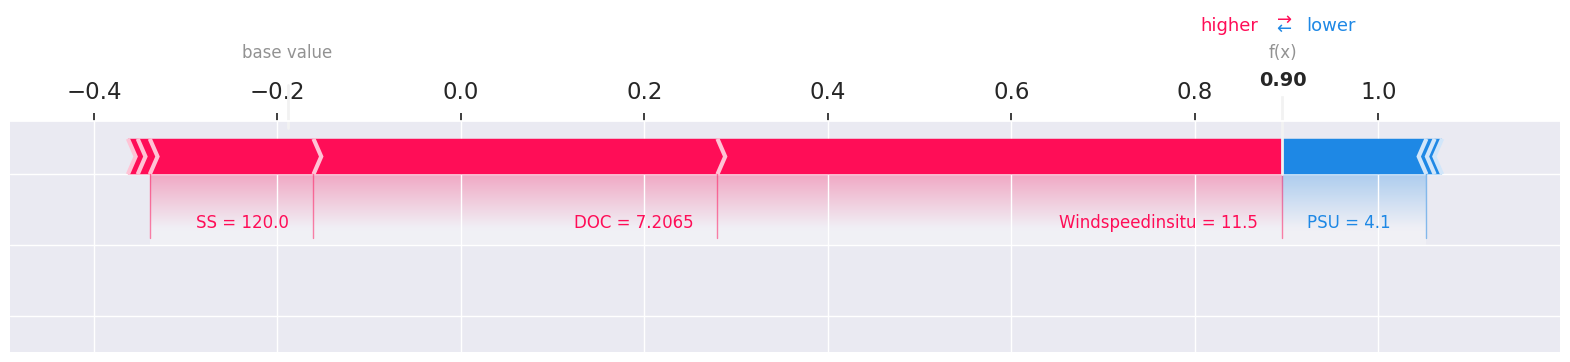

In [78]:
shap.force_plot(explainer.expected_value, shap_values[119,:], show=False, features=X.iloc[119,:],matplotlib=True)
